In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hockey_rink import NHLRink
from scipy.stats import binned_statistic, binned_statistic_2d
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import matplotlib as mpl
import matplotlib.lines as lines


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df_games = pd.read_csv('data/df_Linhac_games_with_xT.csv')
df_move = pd.read_csv('data/df_Linahc_move_with_xT.csv')

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [11]:
x_exit =  25.42857143
y1_exit = -42.5
y2_exit =  42.5

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False
    
l1 = line([x_exit,y1_exit],[x_exit,y2_exit])

In [ ]:
# The concept of exit sequences is adopted from the work of David Sumpter and and Aleksander Andrzejewski on Possession Chains (https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_PossesionChain.html). I do not take any credit for these sequences 

In [12]:
chain_team = df_games.iloc[0]["teaminpossession"]
period = df_games.iloc[0]["period"]
stop_criterion = 0
chain = 0
df_games["exit_seq"] = 0
df_games["exit_seq_team"] = 0
df_games['exit_in_seq'] = 0
for i, row in df_games.iterrows():
        df_games.at[i, "exit_seq"] = chain
        df_games.at[i, "exit_seq_team"] = chain_team

        if (row['eventname'] == 'controlledexit') & (row['teamid'] == chain_team):
                stop_criterion += 2

        if (row['eventname']== 'pass') & (row['outcome_code'] == 0):
                stop_criterion += 1
        
        if (row['teaminpossession'] != chain_team):
                stop_criterion += 1

        if row['period'] != period:
                chain += 1
                stop_criterion = 0
                period = row["period"]
                df_games.at[i, "exit_seq"] = chain
        
        if row["eventname"] == 'shot':
                if row['next_event'] in ['goal', 'save', 'block']:
                        stop_criterion += 1
                else:
                        stop_criterion += 2

        if row["eventname"] in ['goal', 'save', 'block']:
                if row['prev_event'] == 'shot':
                        stop_criterion += 1

        if row["eventname"] in ["offside", 'icing']:
                stop_criterion += 2
        if row['next_event'] == 'faceoff':
                if row['eventname'] not in ['faceoff', 'start', 'goal', 'save', 'block', 'shot']:
                        stop_criterion += 2

        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['next_teaminpossession']

In [13]:
df_passes = df_move[(df_move.eventname == 'pass')].copy()
df_carry = df_move[(df_move.eventname == 'carry')].copy()
df_move_entry = pd.concat([df_passes, df_carry], axis=0)

In [14]:
exit_seqs = df_games['exit_seq'].unique()
len(exit_seqs)

15194

In [15]:
df_games_exit = df_games[df_games.eventname.isin(['pass', 'carry', 'controlledexit'])].copy()
df_games_exit = df_games_exit[(df_games_exit['xadjcoord'] < 0) | (df_games_exit['eventname'] == 'controlledexit')].copy()

In [16]:
df_pre_exit = df_games_exit[((df_games_exit['eventname'] == "controlledexit") & (df_games_exit['outcome'] == 'successful'))
                   | ((df_games_exit['eventname'].shift(-1) == "controlledexit") & (df_games_exit['outcome'].shift(-1) == 'successful'))
                   | ((df_games_exit['eventname'].shift(-2) == "controlledexit") & (df_games_exit['outcome'].shift(-2) == 'successful'))
                   | ((df_games_exit['eventname'].shift(-3) == "controlledexit") & (df_games_exit['outcome'].shift(-3) == 'successful'))
                   ]
# drop unsuccessful exits
print(df_pre_exit.shape)
df_pre_exit = df_pre_exit[(df_pre_exit['eventname'] != "controlledexit") | (df_pre_exit['outcome'] == 'successful')]
df_pre_exit.shape

(9621, 49)


(9158, 49)

In [17]:
df_pre_exit['exit_intersection'] = df_pre_exit.apply(lambda x: intersection(line([x['xadjcoord'], x['yadjcoord']], [x['xadjcoord_end'], x['yadjcoord_end']]), l1), axis=1)
df_pre_exit['x_exit'] = df_pre_exit['exit_intersection'].str[0]
df_pre_exit['y_exit'] = df_pre_exit['exit_intersection'].str[1]

In [18]:
df_pre_exit["exit_lane_int"] = pd.cut(df_pre_exit['y_exit'], bins=85 / 5 * np.arange(-2.5, 3), labels=False)

In [19]:
df_pre_exit["exit_lane_int"].value_counts()

0.0    774
4.0    746
3.0    473
2.0    432
1.0    420
Name: exit_lane_int, dtype: int64

In [20]:
df_pre_exit.loc[df_pre_exit['eventname'] == "controlledexit", "exit_lane"] = pd.cut(df_pre_exit.loc[df_pre_exit['eventname'] == "controlledexit", "yadjcoord"], bins=85 / 5 * np.arange(-2.5, 3), labels=False)

In [21]:
exit_lanes = {
    4: "left",
    3: "middle left",
    2: "middle",
    1: "middle right",
    0: "right"
}

In [22]:
df_pre_exit['exit_lane_name'] = df_pre_exit['exit_lane'].map(exit_lanes)
df_pre_exit['exit_lane_name_int'] = df_pre_exit['exit_lane_int'].map(exit_lanes)


In [23]:
df_pre_exit.loc[df_pre_exit['eventname'] == "controlledexit", "exit_lane"].value_counts()

0.0    816
4.0    815
3.0    354
2.0    350
1.0    320
Name: exit_lane, dtype: int64

In [24]:
df_pre_exit.loc[df_pre_exit['eventname'] == "controlledexit", "exit_lane_int"] = df_pre_exit.loc[df_pre_exit['eventname'].shift(-1) == "controlledexit", 'exit_lane_int'].values

In [25]:
df_pre_exit.loc[df_pre_exit['eventname'] == "controlledexit", "exit_lane_int"].value_counts()

4.0    492
0.0    490
2.0    267
3.0    264
1.0    240
Name: exit_lane_int, dtype: int64

In [26]:
df_pre_exit['exit_lane_name_int'].value_counts()

right           774
left            746
middle left     473
middle          432
middle right    420
Name: exit_lane_name_int, dtype: int64

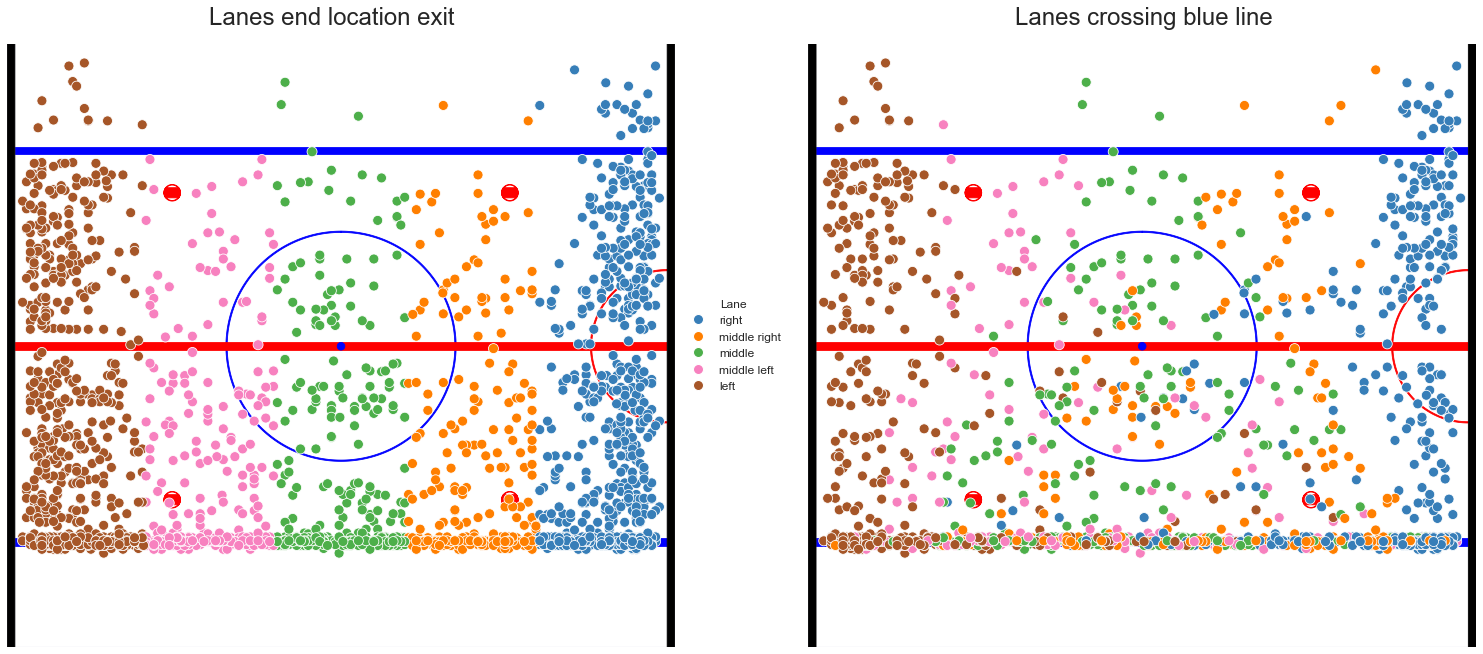

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(16, 18))

rink = NHLRink(rotation=90, net={"visible": False})
rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=True, data=df_pre_exit[df_pre_exit['eventname'] == "controlledexit"], ax=axs[0], hue='exit_lane', draw_kw={"xlim": (x.min(), x.max())}, palette=CB_color_cycle[0:5])

rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_pre_exit[df_pre_exit['eventname'] == "controlledexit"], ax=axs[1], hue='exit_lane_int', draw_kw={"xlim": (x.min(), x.max())}, palette=CB_color_cycle[:5])
#fig.savefig('figs/sequence_exit_lanes.png',bbox_inches='tight')
fig.text(0.3,0.75,'Lanes end location exit', fontweight='regular',fontsize=24)
fig.text(1,0.75,'Lanes crossing blue line', fontweight='regular',fontsize=24)


axs[0].legend(loc="center left",bbox_to_anchor=(1, 0.5), frameon=True, title="Exit Lane", title_fontsize=10, fontsize=10)
legend_elements = [
        lines.Line2D([0], [0], marker='o', color='w', label='right', markerfacecolor=CB_color_cycle[0], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='middle right', markerfacecolor=CB_color_cycle[1], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='middle', markerfacecolor=CB_color_cycle[2], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='middle left', markerfacecolor=CB_color_cycle[3], markersize=10),
        lines.Line2D([0], [0], marker='o', color='w', label='left', markerfacecolor=CB_color_cycle[4], markersize=10),
       ]
legend = axs[0].legend(handles=legend_elements, loc="center left",bbox_to_anchor=(1, 0.5), fontsize=12, prop={'size': 12}, ncol=1, title="Lane", title_fontsize=12)
frame = legend.get_frame()
frame.set_color('white')

plt.subplots_adjust(right=1.4)
plt.show()

fig.savefig('figs/sequence_exit_lanes.png',bbox_inches='tight')


In [33]:
df_pre_exit.loc[~df_pre_exit['xadjcoord_end'].isna(),'eventname'].value_counts()

pass     4922
carry    1581
Name: eventname, dtype: int64

In [34]:
df_rank_exit_seq = df_pre_exit[['exit_seq','xT', 'xT_against','xT_net', 'exit_lane']].groupby('exit_seq').agg({'xT': 'sum', 'xT_against': 'sum', 'xT_net': 'sum', 'exit_lane': 'mean'}).reset_index()
df_rank_exit_seq.shape

(4361, 5)

In [35]:
df_rank_exit_int_seq = df_pre_exit[['exit_seq','xT', 'xT_against','xT_net', 'exit_lane_int']].groupby('exit_seq').agg({'xT': 'sum', 'xT_against': 'sum', 'xT_net': 'sum', 'exit_lane_int': 'mean'}).reset_index()
df_rank_exit_int_seq = df_rank_exit_int_seq.dropna()

In [36]:
df_rank_exit_seq = df_rank_exit_seq.dropna()

In [37]:
df_rank_exit_seq['exit_lane_name'] = df_rank_exit_seq['exit_lane'].map(exit_lanes)
df_rank_exit_int_seq['exit_lane_name_int'] = df_rank_exit_int_seq['exit_lane_int'].map(exit_lanes)

In [38]:
df_rank_exit_seq.sort_values('xT_net', ascending=False).head(20)

,exit_seq,xT,xT_against,xT_net,exit_lane,exit_lane_name
3600,12657,-0.004392,0.252992,0.248600,0.0,right
1774,6379,0.000830,0.214825,0.215655,4.0,left
2430,8620,-0.004339,0.214523,0.210183,0.0,right
4256,14938,0.000399,0.188059,0.188457,2.0,middle
3002,10597,-0.011025,0.195975,0.184950,4.0,left
1507,5526,-0.004245,0.189024,0.184779,0.0,right
3887,13615,0.008180,0.167978,0.176158,4.0,left
1683,6061,-0.004520,0.176584,0.172064,2.0,middle
718,2778,-0.004858,0.174483,0.169625,3.0,middle left
15,44,0.008242,0.157718,0.165960,4.0,left


In [39]:
df_rank_exit_int_seq.sort_values('xT_net', ascending=False).head(20)

,exit_seq,xT,xT_against,xT_net,exit_lane_int,exit_lane_name_int
3600,12657,-0.004392,0.252992,0.248600,2.000000,middle
2430,8620,-0.004339,0.214523,0.210183,0.000000,right
4256,14938,0.000399,0.188059,0.188457,2.000000,middle
1507,5526,-0.004245,0.189024,0.184779,0.000000,right
106,380,-0.005078,0.184337,0.179259,0.000000,right
1683,6061,-0.004520,0.176584,0.172064,2.333333,NaN
718,2778,-0.004858,0.174483,0.169625,0.333333,NaN
3838,13436,0.003932,0.156944,0.160876,0.000000,right
1559,5673,0.000079,0.159977,0.160056,1.333333,NaN
3377,11844,0.000041,0.159014,0.159056,2.333333,NaN


In [40]:
df_rank_exit_lane = df_rank_exit_seq.groupby('exit_lane_name').agg({'xT': 'mean', 'xT_against': 'mean', 'xT_net': 'mean'}).reset_index()
df_rank_exit_int_lane = df_rank_exit_int_seq.groupby('exit_lane_name_int').agg({'xT': 'mean', 'xT_against': 'mean', 'xT_net': 'mean'}).reset_index()

In [41]:
df_rank_exit_lane.sort_values('xT_net', ascending=False)

,exit_lane_name,xT,xT_against,xT_net
0,left,0.000313,0.005945,0.006258
4,right,-0.000315,0.006285,0.005970
3,middle right,-0.000195,0.004000,0.003805
2,middle left,0.000107,0.003170,0.003276
1,middle,-0.000235,-0.000693,-0.000927


In [42]:
df_rank_exit_int_lane.sort_values('xT_net', ascending=False)

,exit_lane_name_int,xT,xT_against,xT_net
4,right,-0.000242,0.004415,0.004173
0,left,-0.000035,0.002958,0.002923
1,middle,-0.000095,0.002062,0.001966
2,middle left,0.000091,0.001764,0.001854
3,middle right,-0.000084,0.001802,0.001718


In [43]:
df_rank_exit_seq_plot = df_rank_exit_int_seq.sort_values('exit_lane_int', ascending=False)

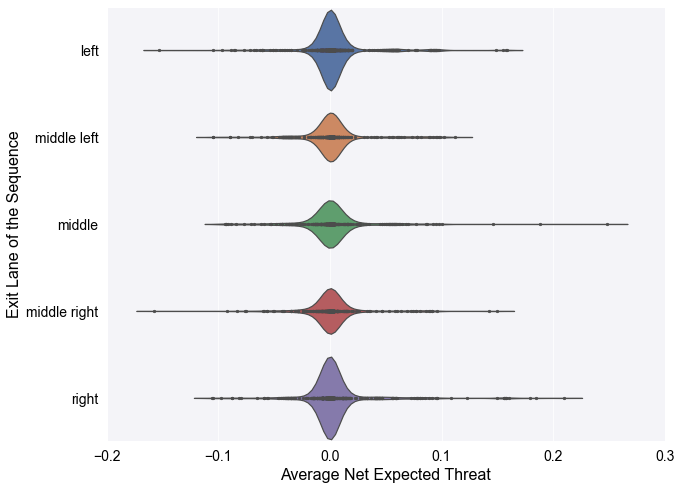

In [85]:
fig, ax = plt.subplots(figsize=(10,8))

text_color = "black"
background = "white"
edge = "white"

sns.set_theme(style="darkgrid")
sns.set_context("paper")

fig.set_facecolor(background)
ax.patch.set_alpha(0.5)

ax.set_xlim(-0.2, 0.3)

sns.violinplot(x=df_rank_exit_seq_plot["xT_net"].round(5), y=df_rank_exit_seq_plot["exit_lane_name_int"], orient='h', inner='point', scale='count', width=0.95)
ax.set_xlabel('Average Net Expected Threat' ,fontsize=16,color=text_color)
ax.set_ylabel('Exit Lane of the Sequence',fontsize=16,color=text_color)

ax.tick_params(axis='x', colors=text_color, labelsize=14)
ax.tick_params(axis='y', colors=text_color, labelsize=14)

plt.show()

fig.savefig('figs/net_expected_threat_exit_lanes_2',bbox_inches='tight')

In [45]:
df_plot_exit = df_pre_exit[df_pre_exit['exit_seq'] == 5526]
df_plot_exit_move = df_plot_exit[df_plot_exit['eventname'] != 'controlledexit']
df_plot_exit_point = df_plot_exit[df_plot_exit['eventname'] == 'controlledexit']

In [46]:
df_plot_exit[['eventname','xadjcoord', 'yadjcoord', 'xadjcoord_end', 'yadjcoord_end']]

,eventname,xadjcoord,yadjcoord,xadjcoord_end,yadjcoord_end
27409,pass,-67.089111,3.267647,-37.918522,-12.323528
27411,pass,-76.142052,11.314705,-60.047932,27.408821
27413,pass,-59.544991,-17.855883,20.422653,-35.458824
27414,controlledexit,20.422653,-35.458824,NaN,NaN


In [47]:
plot_exit_lane_int = df_rank_exit_int_seq.loc[df_rank_exit_int_seq['exit_seq'] == 5526, 'exit_lane_name_int'].values[0]
plot_xT_net = df_rank_exit_int_seq.loc[df_rank_exit_int_seq['exit_seq'] == 5526, 'xT_net'].values[0]
plot_exit_lane_loc = df_rank_exit_seq.loc[df_rank_exit_seq['exit_seq'] == 5526, 'exit_lane_name'].values[0]
plot_exit_lane_int, plot_exit_lane_loc, plot_xT_net

('right', 'right', 0.1847789972040686)

In [48]:
df_rank_exit_seq.loc[df_rank_exit_seq['exit_seq'] == 5526]

,exit_seq,xT,xT_against,xT_net,exit_lane,exit_lane_name
1507,5526,-0.004245,0.189024,0.184779,0.0,right


In [49]:
df_plot_exit_move

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid,outcome_code,is_exit,is_entry,is_blocked,is_saved,is_assist,is_goal,next_event,interruption,next_teamid,next_teaminpossession,prev_event,xadjcoord_end,yadjcoord_end,shot_seq,shot_seq_team,is_shot_seq_team,possession_seq,possession_seq_team,pos_seq_has_exit,xT,xT_against,xT_net,exit_seq,exit_seq_team,exit_in_seq,exit_intersection,x_exit,y_exit,exit_lane_int,exit_lane,exit_lane_name,exit_lane_name_int
27409,71102,40720.0,583,315565,996353.0,824,824.0,59.0,NaN,423.70000,pass,1,powerPlay,4,successful,1,F,2,5,d2d,-67.089111,3.267647,27409,1,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,824,824.0,reception,-37.918522,-12.323528,1192,583.0,0,5014,824.0,1,-0.004447,0.084675,0.080228,5526,824.0,0,"(25.428571429999998, -46.18145304564546)",25.428571,-46.181453,NaN,NaN,NaN,NaN
27411,71102,40720.0,583,73679,996353.0,824,824.0,59.0,NaN,428.76666,pass,1,powerPlay,4,successful,1,F,2,5,outlet,-76.142052,11.314705,27411,1,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,824,824.0,reception,-60.047932,27.408821,1192,583.0,0,5014,824.0,1,0.000263,0.084938,0.085201,5526,824.0,0,"(25.42857143, 112.88530394709304)",25.428571,112.885304,NaN,NaN,NaN,NaN
27413,71102,40720.0,583,315565,996353.0,824,824.0,59.0,NaN,432.13333,pass,1,powerPlay,4,successful,1,F,2,5,stretch,-59.544991,-17.855883,27413,1,1.0,0.0,0.0,0.0,0.0,0.0,controlledexit,0,824,NaN,reception,20.422653,-35.458824,1192,583.0,0,5014,824.0,1,-0.000061,0.019411,0.019350,5526,824.0,0,"(25.428571429999998, -36.560755910784025)",25.428571,-36.560756,0.0,NaN,NaN,right


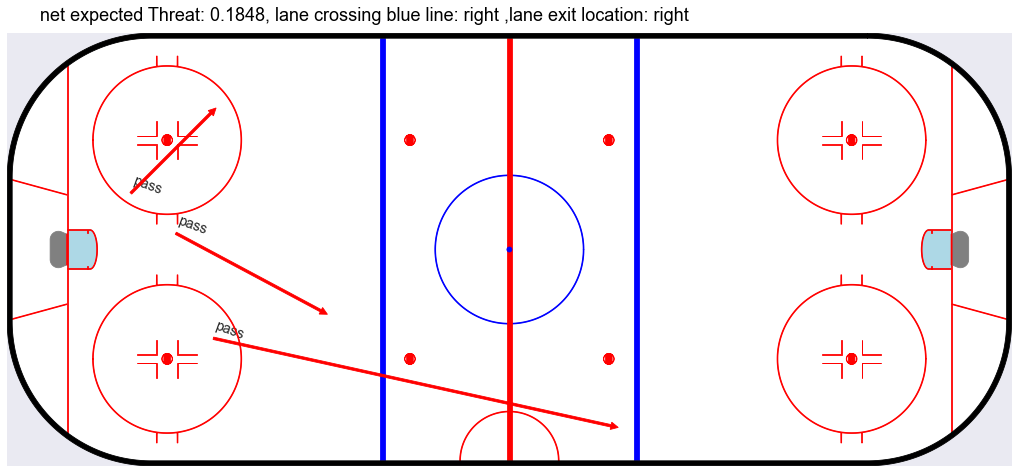

In [76]:
rink = NHLRink()

fig, ax = plt.subplots(figsize=(18, 8))

text_color = "black"
background = "white"
edge = "white"
sns.set_context("paper")
fig.text(0.15,0.9,'net expected Threat: {}, lane crossing blue line: {} ,lane exit location: {}'.format(round(plot_xT_net,4), plot_exit_lane_int, plot_exit_lane_loc), fontweight='regular',fontsize=18,color=text_color)


rink.arrow(data=df_plot_exit_move, x='xadjcoord', y='yadjcoord', x2='xadjcoord_end', y2='yadjcoord_end', ax=ax, color='red', width=0.5, head_width=1.5, head_length=1.5)
#rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_plot_exit[df_plot_exit['eventname'] == 'controlledexit'], ax=ax)

for i,row in df_plot_exit_move.iterrows():
    ax.annotate(row['eventname'], xy=(row['xadjcoord'], row['yadjcoord']), size=14, rotation=-20)

plt.show()

fig.savefig('figs/example_exit_seq',bbox_inches='tight')

# Analysis of exit passes and carries

In [52]:
df_carry['is_exit'].value_counts()

0.0    3102
1.0    1273
Name: is_exit, dtype: int64

In [53]:
df_passes['is_exit'].value_counts()

0.0    16317
1.0     1138
Name: is_exit, dtype: int64

In [54]:
df_exit_carries = df_carry[(df_carry['is_exit'] == 1) & (df_carry['outcome_code'] == 1)].copy()
df_exit_passes = df_passes[(df_passes['is_exit'] == 1) & (df_passes['outcome_code'] == 1)].copy()

In [55]:
df_exit_carries.shape, df_exit_passes.shape

((1273, 50), (116, 50))

In [56]:
df_exit_carries['exit_intersection'] = df_exit_carries.apply(lambda x: intersection(line([x['xadjcoord'], x['yadjcoord']], [x['xadjcoord_end'], x['yadjcoord_end']]), l1), axis=1)
df_exit_carries['x_exit'] = df_exit_carries['exit_intersection'].str[0]
df_exit_carries['y_exit'] = df_exit_carries['exit_intersection'].str[1]

In [57]:
df_exit_passes['exit_intersection'] = df_exit_passes.apply(lambda x: intersection(line([x['xadjcoord'], x['yadjcoord']], [x['xadjcoord_end'], x['yadjcoord_end']]), l1), axis=1)
df_exit_passes['x_exit'] = df_exit_passes['exit_intersection'].str[0]
df_exit_passes['y_exit'] = df_exit_passes['exit_intersection'].str[1]

In [58]:
df_exit_carries["exit_lane_int"] = pd.cut(df_exit_carries['y_exit'], bins=85 / 5 * np.arange(-2.5, 3), labels=False)
df_exit_passes["exit_lane_int"] = pd.cut(df_exit_passes['y_exit'], bins=85 / 5 * np.arange(-2.5, 3), labels=False)


In [59]:
df_exit_passes["exit_lane"] = pd.cut(df_exit_passes["yadjcoord_end"], bins=85 / 5 * np.arange(-2.5, 3), labels=False)
df_exit_carries["exit_lane"] = pd.cut(df_exit_carries["yadjcoord_end"], bins=85 / 5 * np.arange(-2.5, 3), labels=False)

In [60]:
df_exit_carries['exit_lane'].value_counts()

4    363
0    356
3    188
2    186
1    180
Name: exit_lane, dtype: int64

In [61]:
df_exit_carries['exit_lane_int'].value_counts()

4.0    270
0.0    255
3.0    174
1.0    144
2.0    142
Name: exit_lane_int, dtype: int64

In [62]:
df_exit_passes['exit_lane'].value_counts()

0    52
4    34
2    15
3     9
1     6
Name: exit_lane, dtype: int64

In [63]:
df_exit_passes['exit_lane_int'].value_counts()

0.0    29
4.0    17
1.0     7
2.0     7
3.0     7
Name: exit_lane_int, dtype: int64

In [64]:
df_exit_passes[['xT', 'xT_against','xT_net', 'exit_lane']].groupby('exit_lane').mean().sort_values('xT_net', ascending=False)

,xT,xT_against,xT_net
exit_lane,,,
4,0.000454,0.014842,0.015295
0,-0.000455,0.013837,0.013382
1,0.000034,0.008909,0.008943
2,-0.000041,0.007562,0.007521
3,-0.000494,0.005273,0.004779


In [65]:
df_exit_passes[['xT', 'xT_against','xT_net', 'exit_lane_int']].groupby('exit_lane_int').mean().sort_values('xT_net', ascending=False)

,xT,xT_against,xT_net
exit_lane_int,,,
4.0,0.000050,0.010647,0.010697
1.0,-0.000360,0.008329,0.007969
2.0,-0.000067,0.007675,0.007608
3.0,-0.000212,0.006978,0.006766
0.0,-0.000428,0.004437,0.004010


In [66]:
df_exit_carries[['xT', 'xT_against','xT_net', 'exit_lane']].groupby('exit_lane').mean().sort_values('xT_net', ascending=False)

,xT,xT_against,xT_net
exit_lane,,,
2,0.000033,0.002507,0.002540
3,0.000637,0.001761,0.002398
1,0.000091,0.001356,0.001448
4,0.000740,0.000552,0.001292
0,0.000066,-0.000174,-0.000109


In [67]:
df_exit_carries[['xT', 'xT_against','xT_net', 'exit_lane_int']].groupby('exit_lane_int').mean().sort_values('xT_net', ascending=False)

,xT,xT_against,xT_net
exit_lane_int,,,
3.0,0.000813,1.674756e-03,0.002488
2.0,0.000200,2.056825e-03,0.002257
4.0,0.000690,7.674383e-04,0.001458
1.0,0.000033,8.063168e-04,0.000839
0.0,0.000073,2.886542e-07,0.000073
